# Perception and Action Course Project

In [1]:
# imports
from enum import Enum, auto
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm

SEED = np.random.seed(42)
sns.set_theme()
warnings.simplefilter('ignore')

In [2]:
# prepare data
df = pd.read_csv('./ploscompbio_pucks/data/puck_data.csv', sep='\t', encoding='utf8')
df['Press Rolling Average'] = df['PressTime'].rolling(7).mean()
df['Distance Rolling Average'] = df['DistToTarget'].rolling(7).mean()

# for further processing put dataframes based on their condition and phase into separate frames
mapping = {
    'Condition': {
        1: 'Light-to-heavy',
        2: 'Heavy-to-light'
    },
    'Phase': {
        1: 'Prior',
        2: 'Feedback',
        3: 'No Feedback',
        4: 'Collisions and No Feedback' 
    }
}

# remap values
df = df.replace(mapping)

df.describe()

Trial  StartPosition  EndPosition  DistToTarget    DistMoved  \
count  7200.000000    7200.000000  6400.000000   7200.000000  6400.000000   
mean     69.944444       1.997479     5.495392      3.002521     3.500862   
std      51.747055       1.156613     2.908972      1.156613     3.249942   
min       1.000000       0.000538     0.255766      1.000091     0.019565   
25%      29.000000       0.982081     4.104473      1.995347     1.497057   
50%      59.000000       1.995608     4.853666      3.004392     2.745664   
75%      96.000000       3.004653     5.976427      4.017919     4.426841   
max     200.000000       3.999909    61.745759      4.999462    60.382678   

         PressTime     AbsError        Error         Mass  \
count  7200.000000  6400.000000  6400.000000  6400.000000   
mean      0.965139     1.588654     0.495392     2.000000   
std       0.438878     2.486635     2.908972     0.433047   
min       0.040000     0.000502    -4.744234     1.500000   
25%       0.660000     0.420114    -0.895527     1.500000   
50%       0.900000     0.922895    -0.146334     2.000000   
75%       1.219999     1.820752     0.976427     2.500000   
max       3.439997    56.745759    56.745759     2.500000   

       Press Rolling Average  Distance Rolling Average  
count            7194.000000               7194.000000  
mean                0.964894                  3.002230  
std                 0.306821                  0.429457  
min                 0.091429                  1.607305  
25%                 0.785714                  2.700583  
50%                 0.934285                  2.997476  
75%                 1.117142                  3.294928  
max                 2.317141                  4.471749

## Descriptive Statistics and Plots

In [3]:
def newtonian_relationship(
    distance_to_target: np.ndarray,
    mass: float,
    gravitational_acceleration: float = 9.80665,
    surface_friction: float = 4e-2,
) -> np.ndarray:
    """A vectorized function of the optimal newtonian relationship
    T_{press} = \sqrt{\frac{2\mu gm^2}{F^2}\delta x} \propto m \cdot \sqrt{\delta x}

    Args:
        distance_to_target (np.ndarray): distances to apply function on
        mass (float): the mass of the object
        gravitational_acceleration (float): newton's constant
        surface_friction (float): friction of the surface

    Returns:
        np.ndarray: optimal newton estimate for the tpress
    """
    # for model difference it does not make any difference at all / propto already implemented
    def fn(distance):
        N = mass * gravitational_acceleration
        f1 = 2. * surface_friction * gravitational_acceleration * mass**2.
        tpress = np.sqrt((f1 / (3 * N)) * distance)
        return tpress

    return np.vectorize(fn)(distance_to_target)

# prepare plotting dataframes
light_to_heavy = df[df['Condition'] == 'Light-to-heavy']
light_to_heavy.loc[(light_to_heavy['Mass'] == 1.5), 'Phase'] = 'Feedback 1.5'
light_to_heavy.loc[(light_to_heavy['Mass'] == 2.0), 'Phase'] = 'Feedback 2.0'
l2h_order = ['Prior', 'Feedback 1.5', 'Feedback 2.0', 'No Feedback', 'Collisions and No Feedback']

heavy_to_light = df[df['Condition'] != 'Light-to-heavy']
heavy_to_light.loc[(heavy_to_light['Mass'] == 2.5), 'Phase'] = 'Feedback 2.5'
heavy_to_light.loc[(heavy_to_light['Mass'] == 2.0), 'Phase'] = 'Feedback 2.0'
h2l_order = ['Prior', 'Feedback 2.5', 'Feedback 2.0', 'No Feedback', 'Collisions and No Feedback']

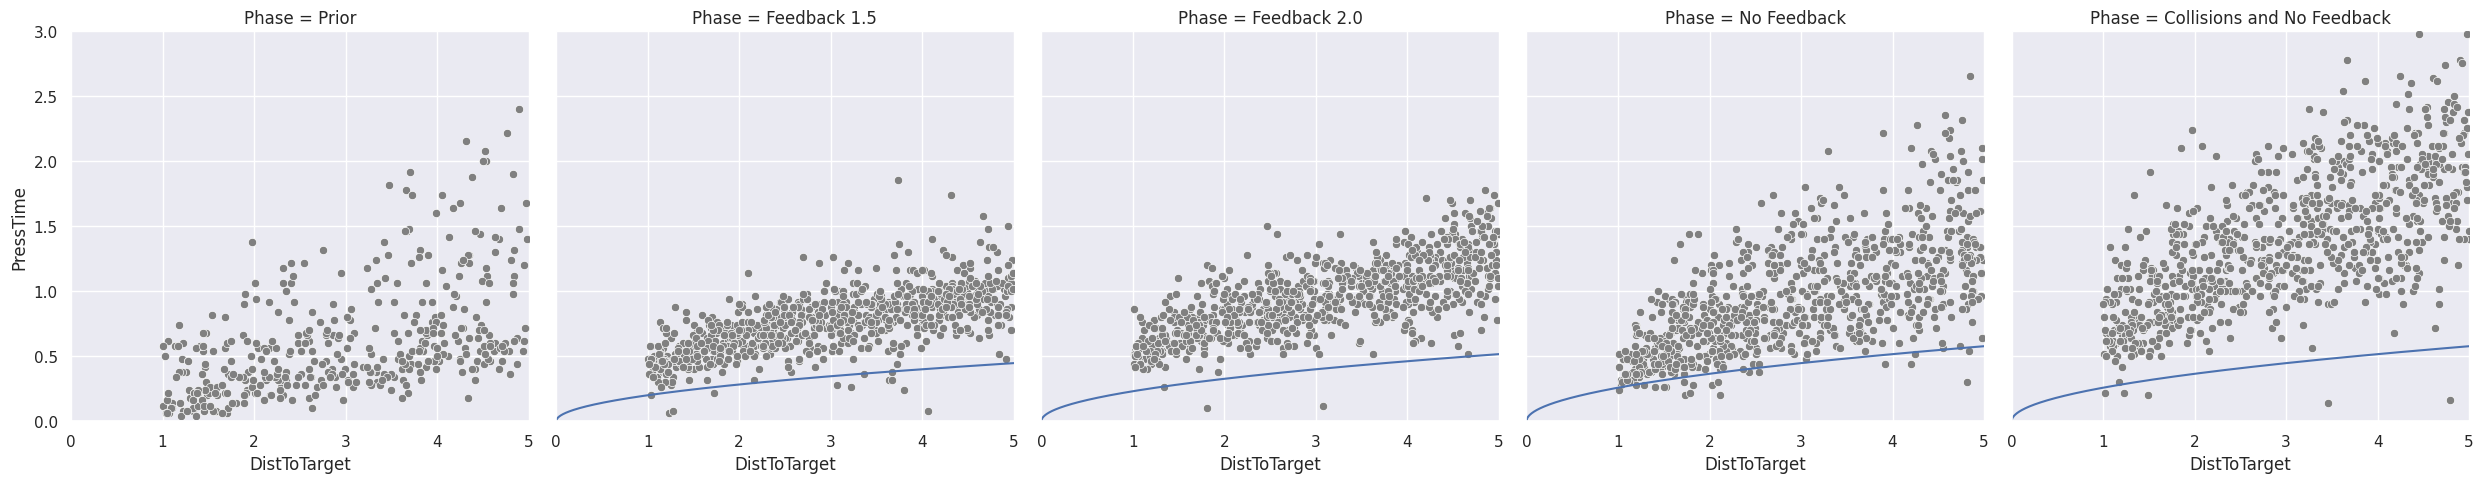

In [4]:
def plot_fig2(df: pd.DataFrame, order: list[str]) -> plt.Figure:
    fig = sns.FacetGrid(df, col='Phase', height=5, xlim=[0, 5], ylim=[0, 3], col_order=order)
    fig.map(sns.scatterplot, 'DistToTarget', 'PressTime', color='gray')
    for col, ax in zip(order, fig.fig.axes):
        if col == 'Prior': continue
        tmp = df[df['Phase'] == col]
        mass = tmp['Mass'].unique()[0]
        linspace = np.linspace(0.0, 5.0, num=len(tmp))
        newtonian = newtonian_relationship(linspace, mass)
        ax.plot(linspace, newtonian)

plot_fig2(light_to_heavy, l2h_order)

In [5]:
# analyzing target participant data
TARGET_PARTICIPANT='PF23EN'
data = df[df['Subject'] == TARGET_PARTICIPANT]

# extract phases from data
target_data = {}
for col in data['Phase'].unique().tolist():
    tmp = data[data['Phase'] == col]
    target_data[col] = {
        'distance': tmp['DistToTarget'].to_numpy(),
        'press_time': tmp['PressTime'].to_numpy()
    }

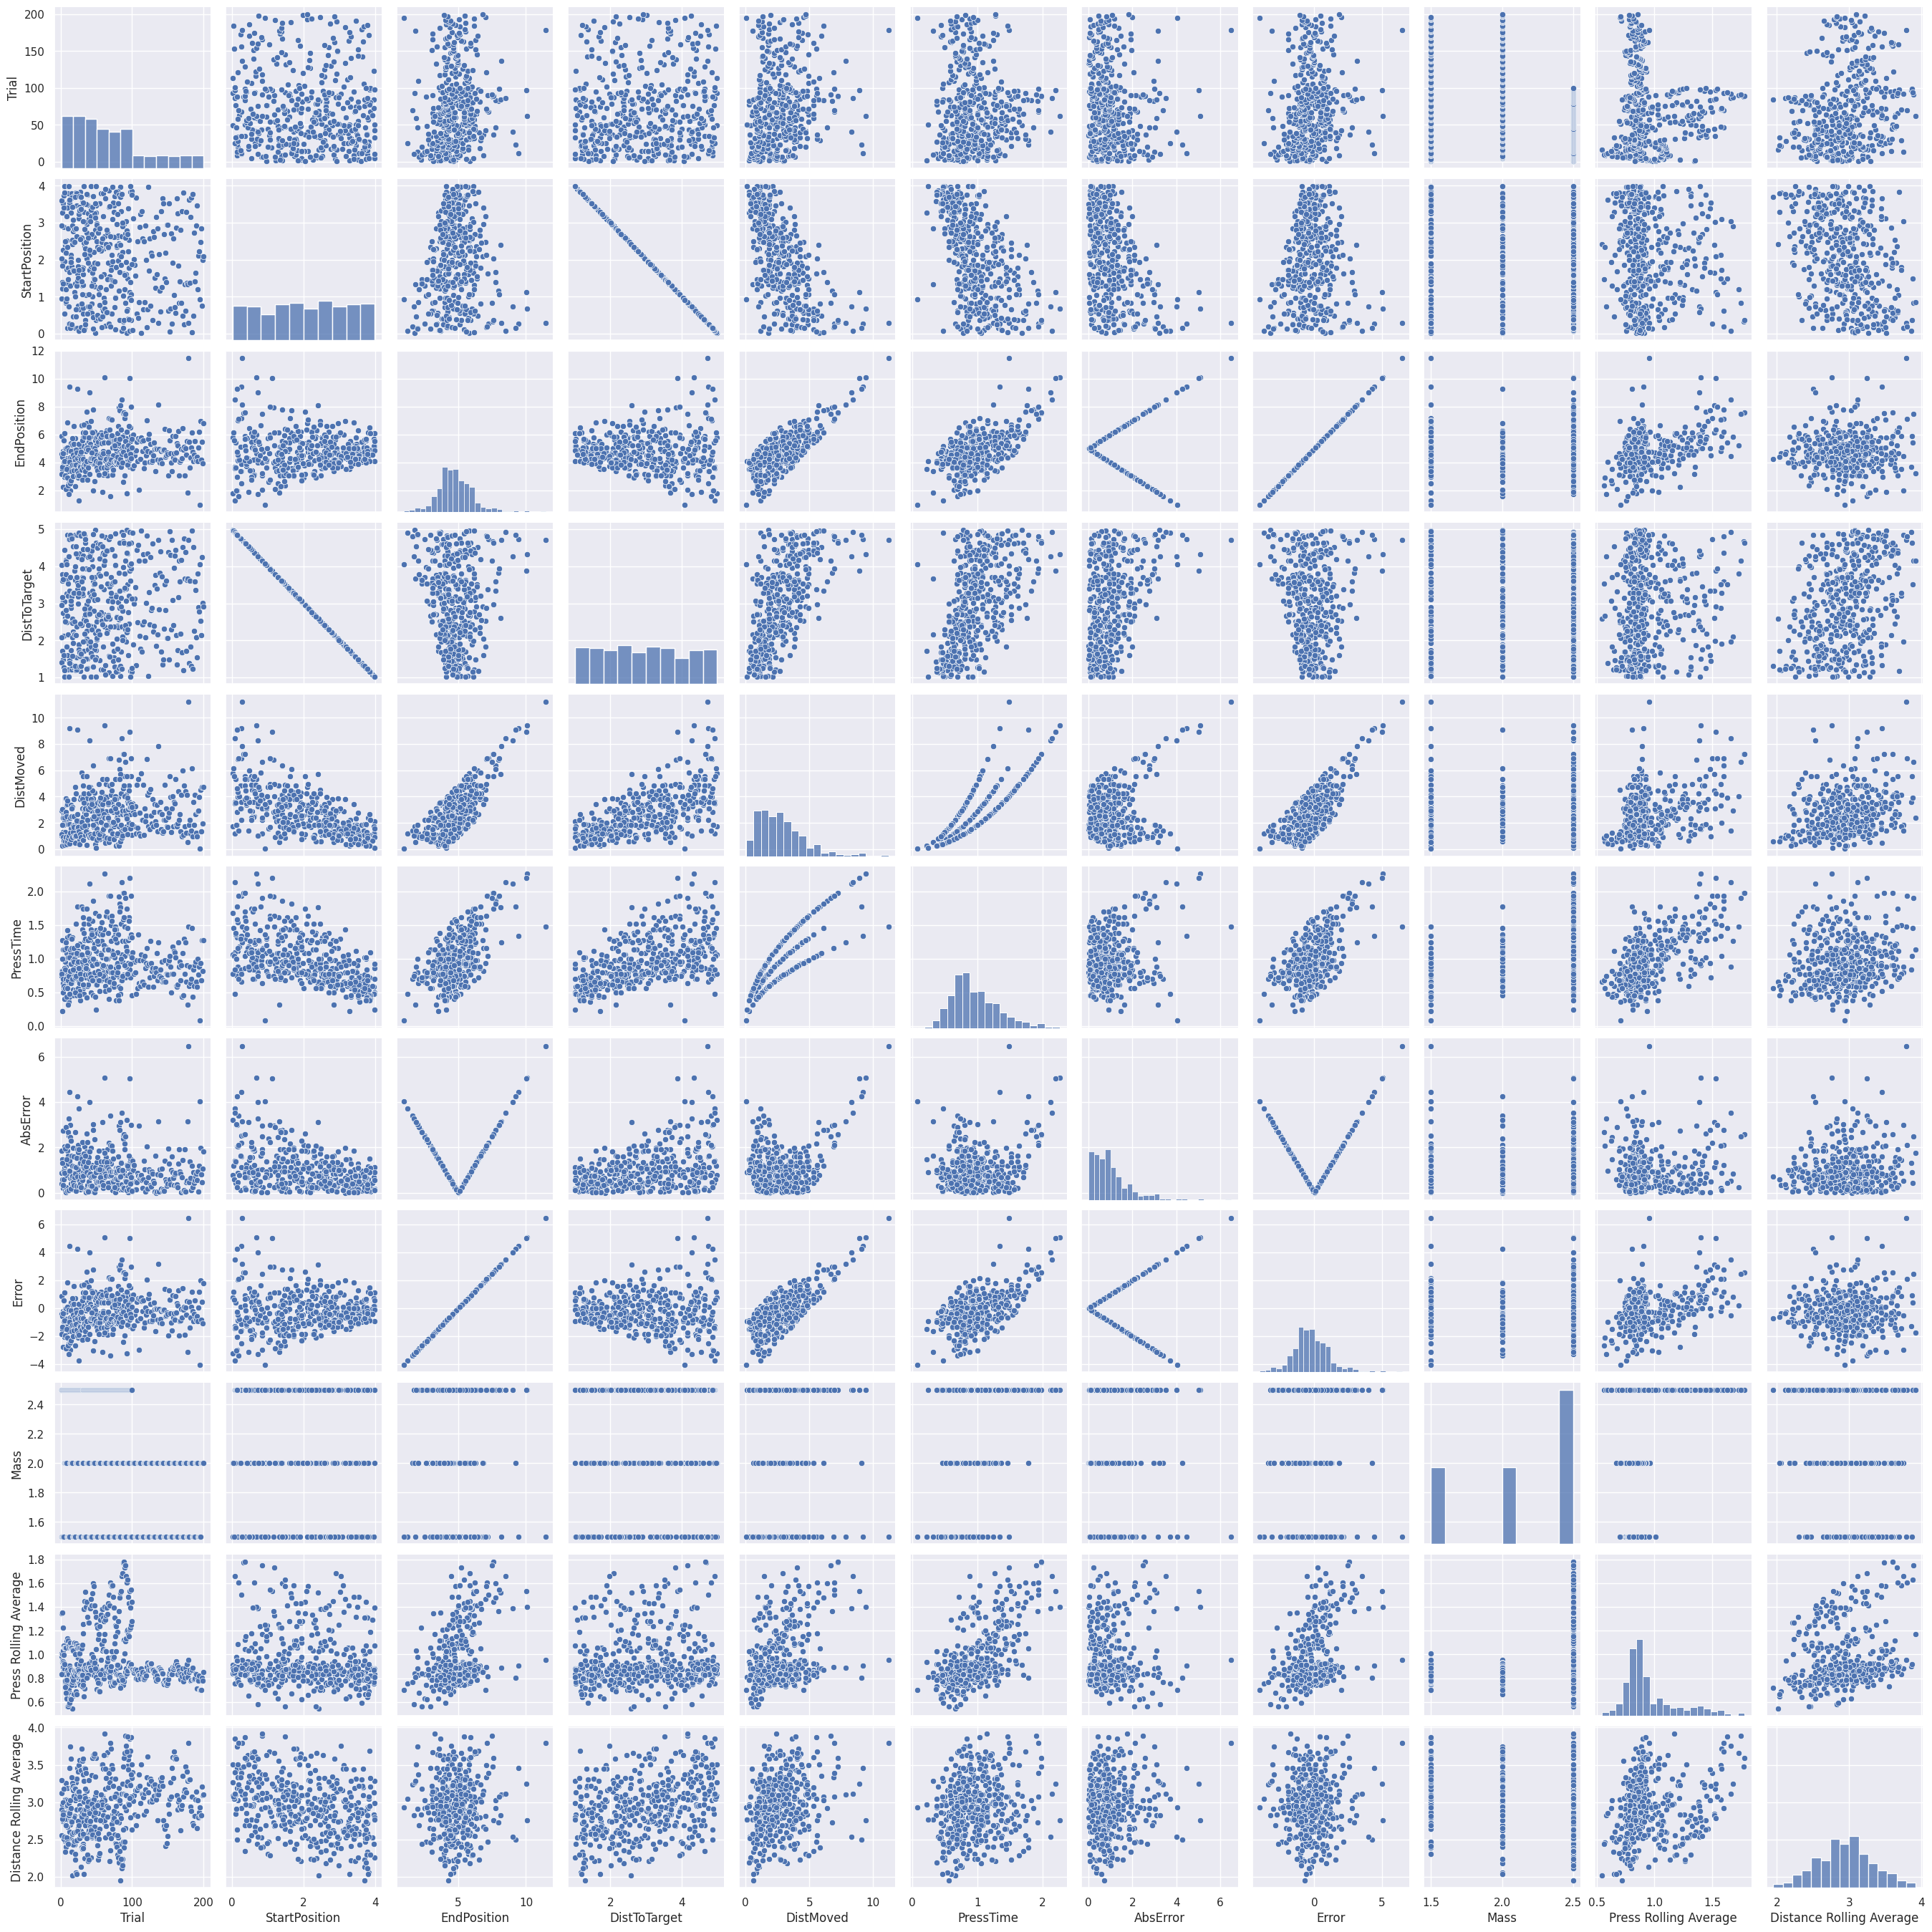

In [6]:
# participant distributions over press time and distance to target
# grid = sns.FacetGrid(data, col='Phase', height=5)
# grid.map(sns.histplot, 'DistToTarget', kde=True, stat='density')
# grid.map(sns.scatterplot, 'DistToTarget', 'PressTime')
sns.pairplot(data)

In [19]:
class NewtonianRelationship(Enum):
    """Potential Newtonian relationships to be modeled"""
    optimal = auto()
    linear = auto()
    square_root = auto()

class NewtonianInteractionModel:
    def __init__(self, data: dict[str, dict[str, np.ndarray]]):
        self.model_dict = {k: pm.Model(f'Newtonian Interaction Model - Phase {k}') for k in data.keys()}
        self.inference_data = {}
        self.prior_predictive = {}
        self.posterior_predictive = {}

    def build_model(self,
                    data: dict[str, dict[str, np.ndarray]],
                    relationship: NewtonianRelationship = NewtonianRelationship.square_root
                    ):
        
        # assert perceptual_uncertainties.shape == observed_press_time.shape, f"Observed variables' shape do not match {perceptual_uncertainties.shape} and {observed_press_time.shape}."

        for k, v in data.items():
            perceptual_uncertainties = v['distance']
            observed_press_time = v['press_time']

            with self.model_dict[k]:
                x_ij = pm.Normal('perceptual_uncertainties')

                x_percept = pm.LogNormal(
                    'x_ij^{per}',
                    mu=x_ij,
                    sigma=0.05,
                    observed=perceptual_uncertainties)

                puck_mass = pm.Gamma('m_jk', 6, 2.5)
                
                if relationship == NewtonianRelationship.square_root:
                    newtonian = pm.Deterministic('t^{int}', puck_mass * np.sqrt(x_percept))
                elif relationship == NewtonianRelationship.optimal:
                    newtonian = pm.Deterministic('t^{int}', newtonian_relationship(x_percept, puck_mass))
                elif relationship == NewtonianRelationship.linear:
                    newtonian = pm.Deterministic('t^{int}', x_percept)
                else:
                    raise ValueError(f'Newtonian relationship: {relationship} is unknown.')

                sigma_t = pm.Gamma('sigma^t', 1.2, 5)
                observed_press_time = pm.LogNormal('t_ij',
                                                newtonian,
                                                sigma_t,
                                                observed=observed_press_time)

            pm.model_to_graphviz(self.model_dict[k])

    
    def sample(self,
               phase: str,
               **kwargs,
    ) -> tuple[az.InferenceData, az.InferenceData, az.InferenceData]:

        assert phase in self.model_dict.keys(), f'Phase: {phase} is not a valid.'
        with self.model_dict[phase]:
            # defaults to NUTS sampler
            idata = pm.sample(draws=10000, **kwargs)
            prior_predictive = pm.sample_prior_predictive(samples=1000, random_seed=SEED)
            posterior_predictive = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=SEED)

        self.inference_data[phase] = idata
        self.prior_predictive[phase] = prior_predictive
        self.posterior_predictive[phase] = posterior_predictive

        return idata, prior_predictive, posterior_predictive

In [20]:
newtonian_model = NewtonianInteractionModel(target_data)
newtonian_model.build_model(target_data)

In [21]:
idata, prior_predictive, posterior_predictive = newtonian_model.sample(phase='No Feedback')

In [22]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

array([<Axes: xlabel='Newtonian Interaction Model - Phase No Feedback::x_ij^{per} / Newtonian Interaction Model - Phase No Feedback::x_ij^{per}'>,
       <Axes: xlabel='Newtonian Interaction Model - Phase No Feedback::t_ij / Newtonian Interaction Model - Phase No Feedback::t_ij'>],
      dtype=object)

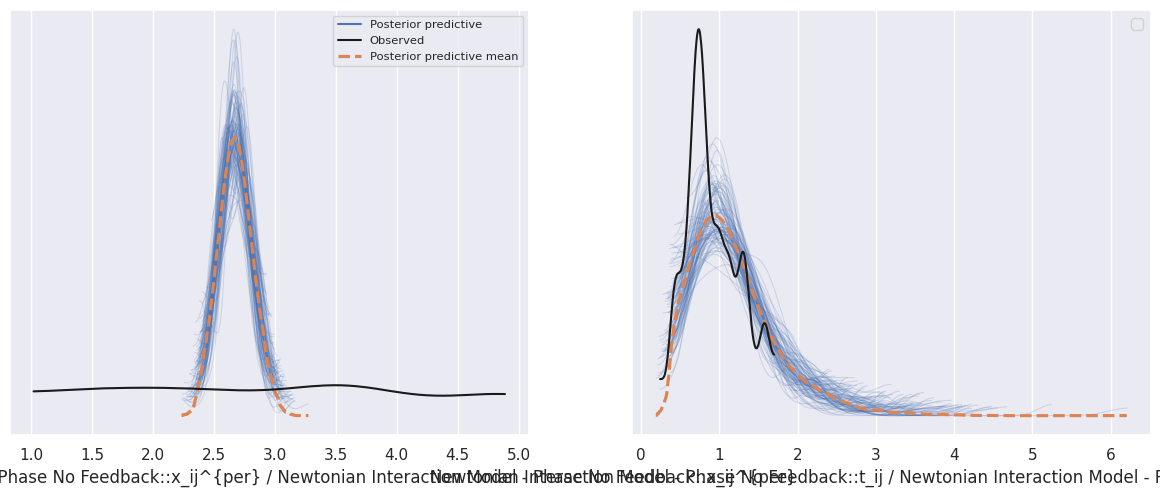

In [23]:
az.plot_ppc(idata, num_pp_samples=100)

array([[<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::perceptual_uncertainties'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::perceptual_uncertainties'}>],
       [<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::m_jk'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::m_jk'}>],
       [<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::sigma^t'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::sigma^t'}>],
       [<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}'}>]],
      dtype=object)

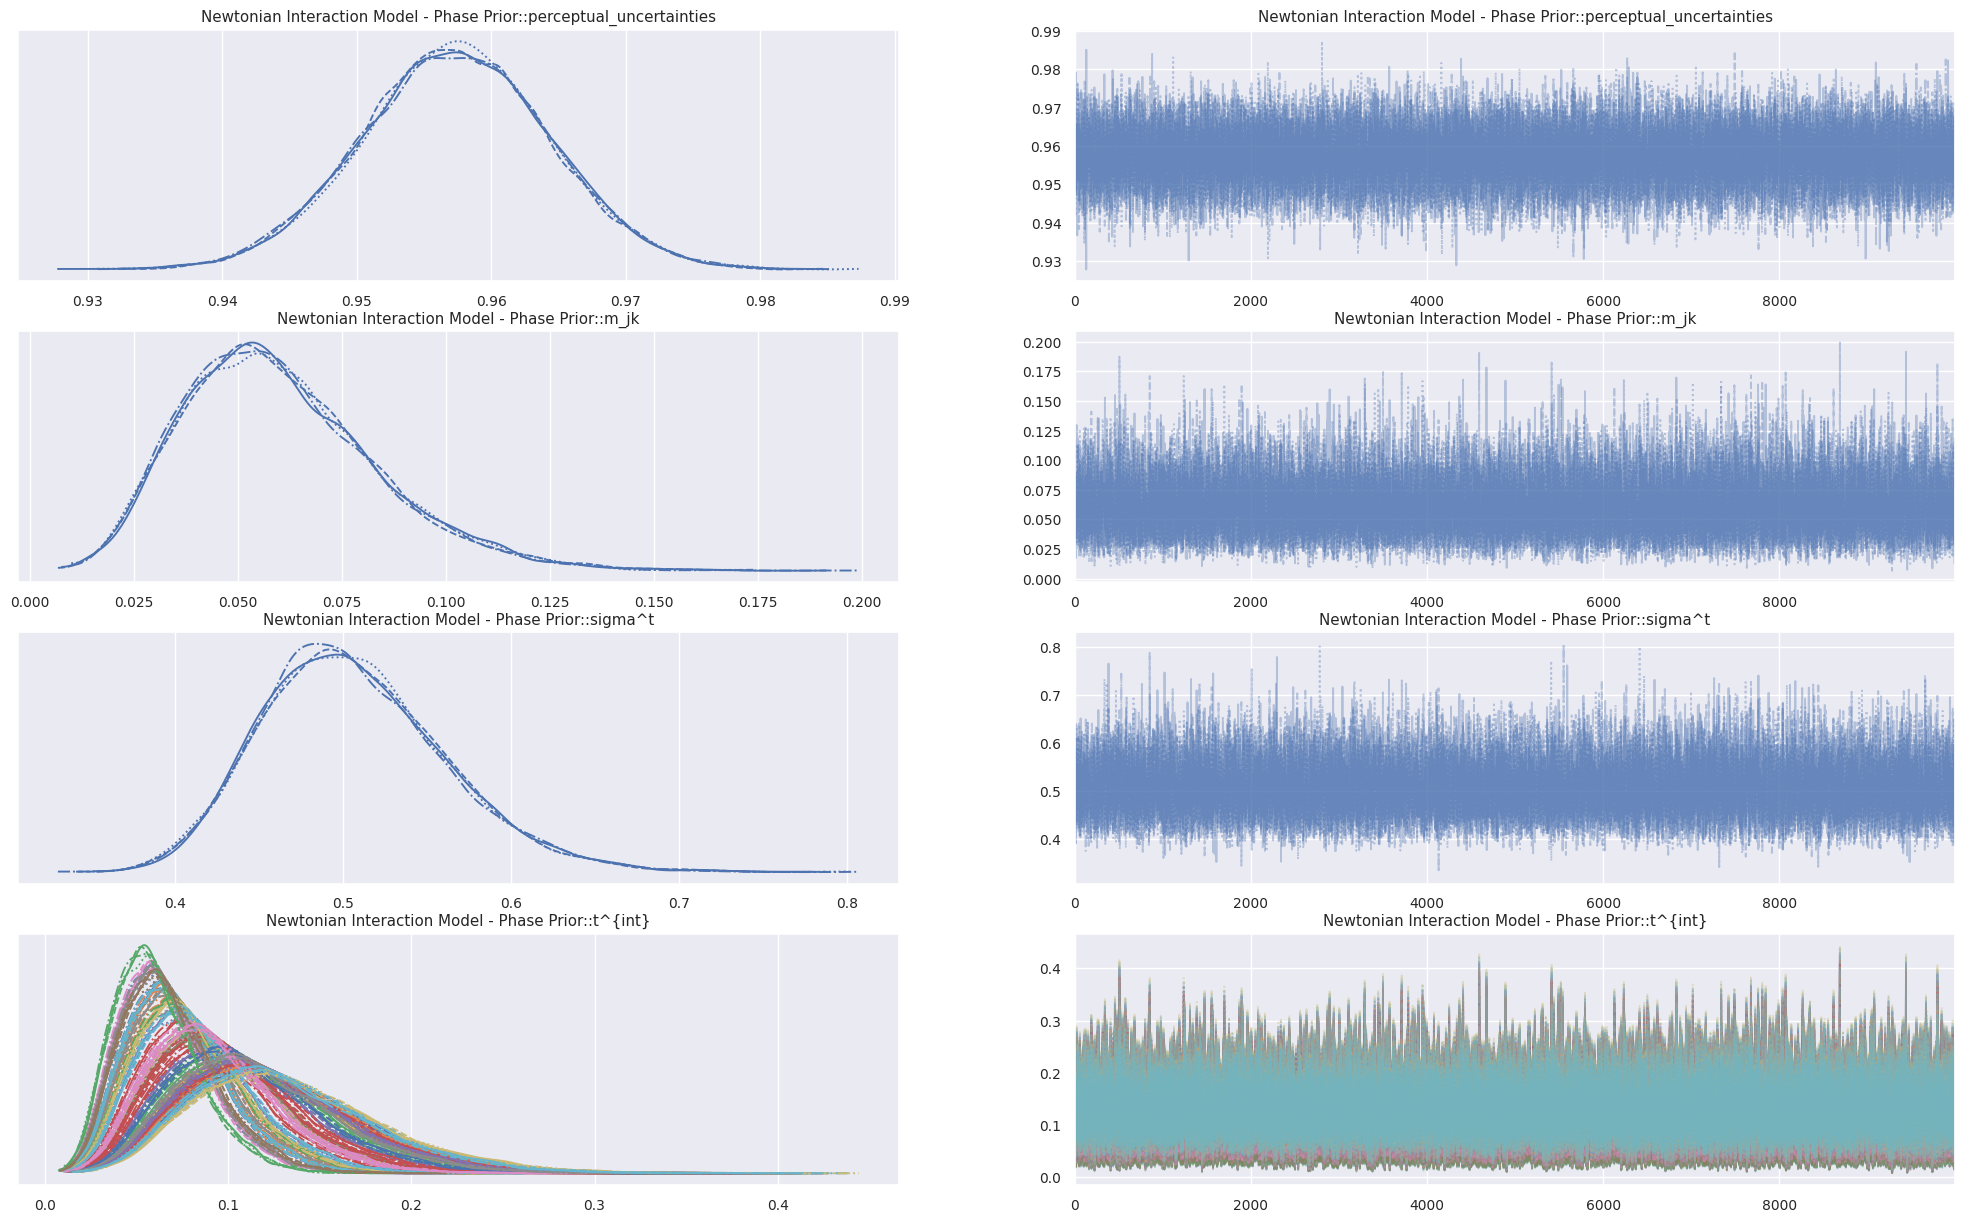

In [10]:
az.plot_trace(idata, figsize=(25, 15))

In [11]:
prior_predictive

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

MemoryError: Unable to allocate 114. GiB for an array with shape (15285423311,) and data type float64

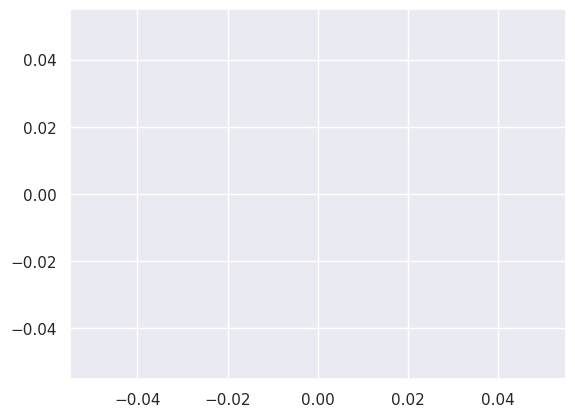

In [12]:
sns.histplot(prior_predictive.to_dataframe(), kde=True, stat='density')

In [13]:
az.summary(idata)

mean     sd  hdi_3%  \
Newtonian Interaction Model - Phase Prior::perc...  0.957  0.007   0.944   
Newtonian Interaction Model - Phase Prior::m_jk     0.060  0.023   0.021   
Newtonian Interaction Model - Phase Prior::sigma^t  0.506  0.055   0.407   
Newtonian Interaction Model - Phase Prior::t^{i...  0.121  0.047   0.042   
Newtonian Interaction Model - Phase Prior::t^{i...  0.117  0.045   0.041   
Newtonian Interaction Model - Phase Prior::t^{i...  0.105  0.041   0.036   
Newtonian Interaction Model - Phase Prior::t^{i...  0.087  0.034   0.030   
Newtonian Interaction Model - Phase Prior::t^{i...  0.105  0.041   0.036   
Newtonian Interaction Model - Phase Prior::t^{i...  0.097  0.038   0.034   
Newtonian Interaction Model - Phase Prior::t^{i...  0.123  0.048   0.043   
Newtonian Interaction Model - Phase Prior::t^{i...  0.095  0.037   0.033   
Newtonian Interaction Model - Phase Prior::t^{i...  0.132  0.051   0.046   
Newtonian Interaction Model - Phase Prior::t^{i...  0.066  0.026   0.023   
Newtonian Interaction Model - Phase Prior::t^{i...  0.072  0.028   0.025   
Newtonian Interaction Model - Phase Prior::t^{i...  0.073  0.028   0.025   
Newtonian Interaction Model - Phase Prior::t^{i...  0.110  0.042   0.038   
Newtonian Interaction Model - Phase Prior::t^{i...  0.102  0.039   0.035   
Newtonian Interaction Model - Phase Prior::t^{i...  0.066  0.026   0.023   
Newtonian Interaction Model - Phase Prior::t^{i...  0.096  0.037   0.033   
Newtonian Interaction Model - Phase Prior::t^{i...  0.128  0.050   0.044   
Newtonian Interaction Model - Phase Prior::t^{i...  0.068  0.026   0.024   
Newtonian Interaction Model - Phase Prior::t^{i...  0.118  0.046   0.041   
Newtonian Interaction Model - Phase Prior::t^{i...  0.132  0.051   0.046   
Newtonian Interaction Model - Phase Prior::t^{i...  0.128  0.050   0.044   
Newtonian Interaction Model - Phase Prior::t^{i...  0.075  0.029   0.026   
Newtonian Interaction Model - Phase Prior::t^{i...  0.114  0.044   0.039   
Newtonian Interaction Model - Phase Prior::t^{i...  0.124  0.048   0.043   
Newtonian Interaction Model - Phase Prior::t^{i...  0.082  0.032   0.029   
Newtonian Interaction Model - Phase Prior::t^{i...  0.125  0.049   0.043   
Newtonian Interaction Model - Phase Prior::t^{i...  0.065  0.025   0.023   
Newtonian Interaction Model - Phase Prior::t^{i...  0.075  0.029   0.026   
Newtonian Interaction Model - Phase Prior::t^{i...  0.093  0.036   0.032   
Newtonian Interaction Model - Phase Prior::t^{i...  0.072  0.028   0.025   
Newtonian Interaction Model - Phase Prior::t^{i...  0.125  0.048   0.043   
Newtonian Interaction Model - Phase Prior::t^{i...  0.078  0.030   0.027   
Newtonian Interaction Model - Phase Prior::t^{i...  0.079  0.030   0.027   
Newtonian Interaction Model - Phase Prior::t^{i...  0.098  0.038   0.034   
Newtonian Interaction Model - Phase Prior::t^{i...  0.129  0.050   0.045   
Newtonian Interaction Model - Phase Prior::t^{i...  0.119  0.046   0.041   
Newtonian Interaction Model - Phase Prior::t^{i...  0.090  0.035   0.031   
Newtonian Interaction Model - Phase Prior::t^{i...  0.066  0.026   0.023   
Newtonian Interaction Model - Phase Prior::t^{i...  0.080  0.031   0.028   
Newtonian Interaction Model - Phase Prior::t^{i...  0.083  0.032   0.029   
Newtonian Interaction Model - Phase Prior::t^{i...  0.109  0.042   0.038   
Newtonian Interaction Model - Phase Prior::t^{i...  0.125  0.049   0.044   
Newtonian Interaction Model - Phase Prior::t^{i...  0.061  0.024   0.021   
Newtonian Interaction Model - Phase Prior::t^{i...  0.123  0.048   0.043   
Newtonian Interaction Model - Phase Prior::t^{i...  0.120  0.047   0.042   
Newtonian Interaction Model - Phase Prior::t^{i...  0.068  0.026   0.024   
Newtonian Interaction Model - Phase Prior::t^{i...  0.093  0.036   0.032   
Newtonian Interaction Model - Phase Prior::t^{i...  0.116  0.045   0.040   
Newtonian Interaction Model - Phase Prior::t^{i...  0.134  0.052   0.047   
Newtonian Interaction Mod

array([[<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::perceptual_uncertainties'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::m_jk'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::sigma^t'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n0'}>],
       [<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n1'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n2'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n3'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n4'}>],
       [<Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n5'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}\n6'}>,
        <Axes: title={'center': 'Newtonian Interaction Model - Phase Prior::t^{int}

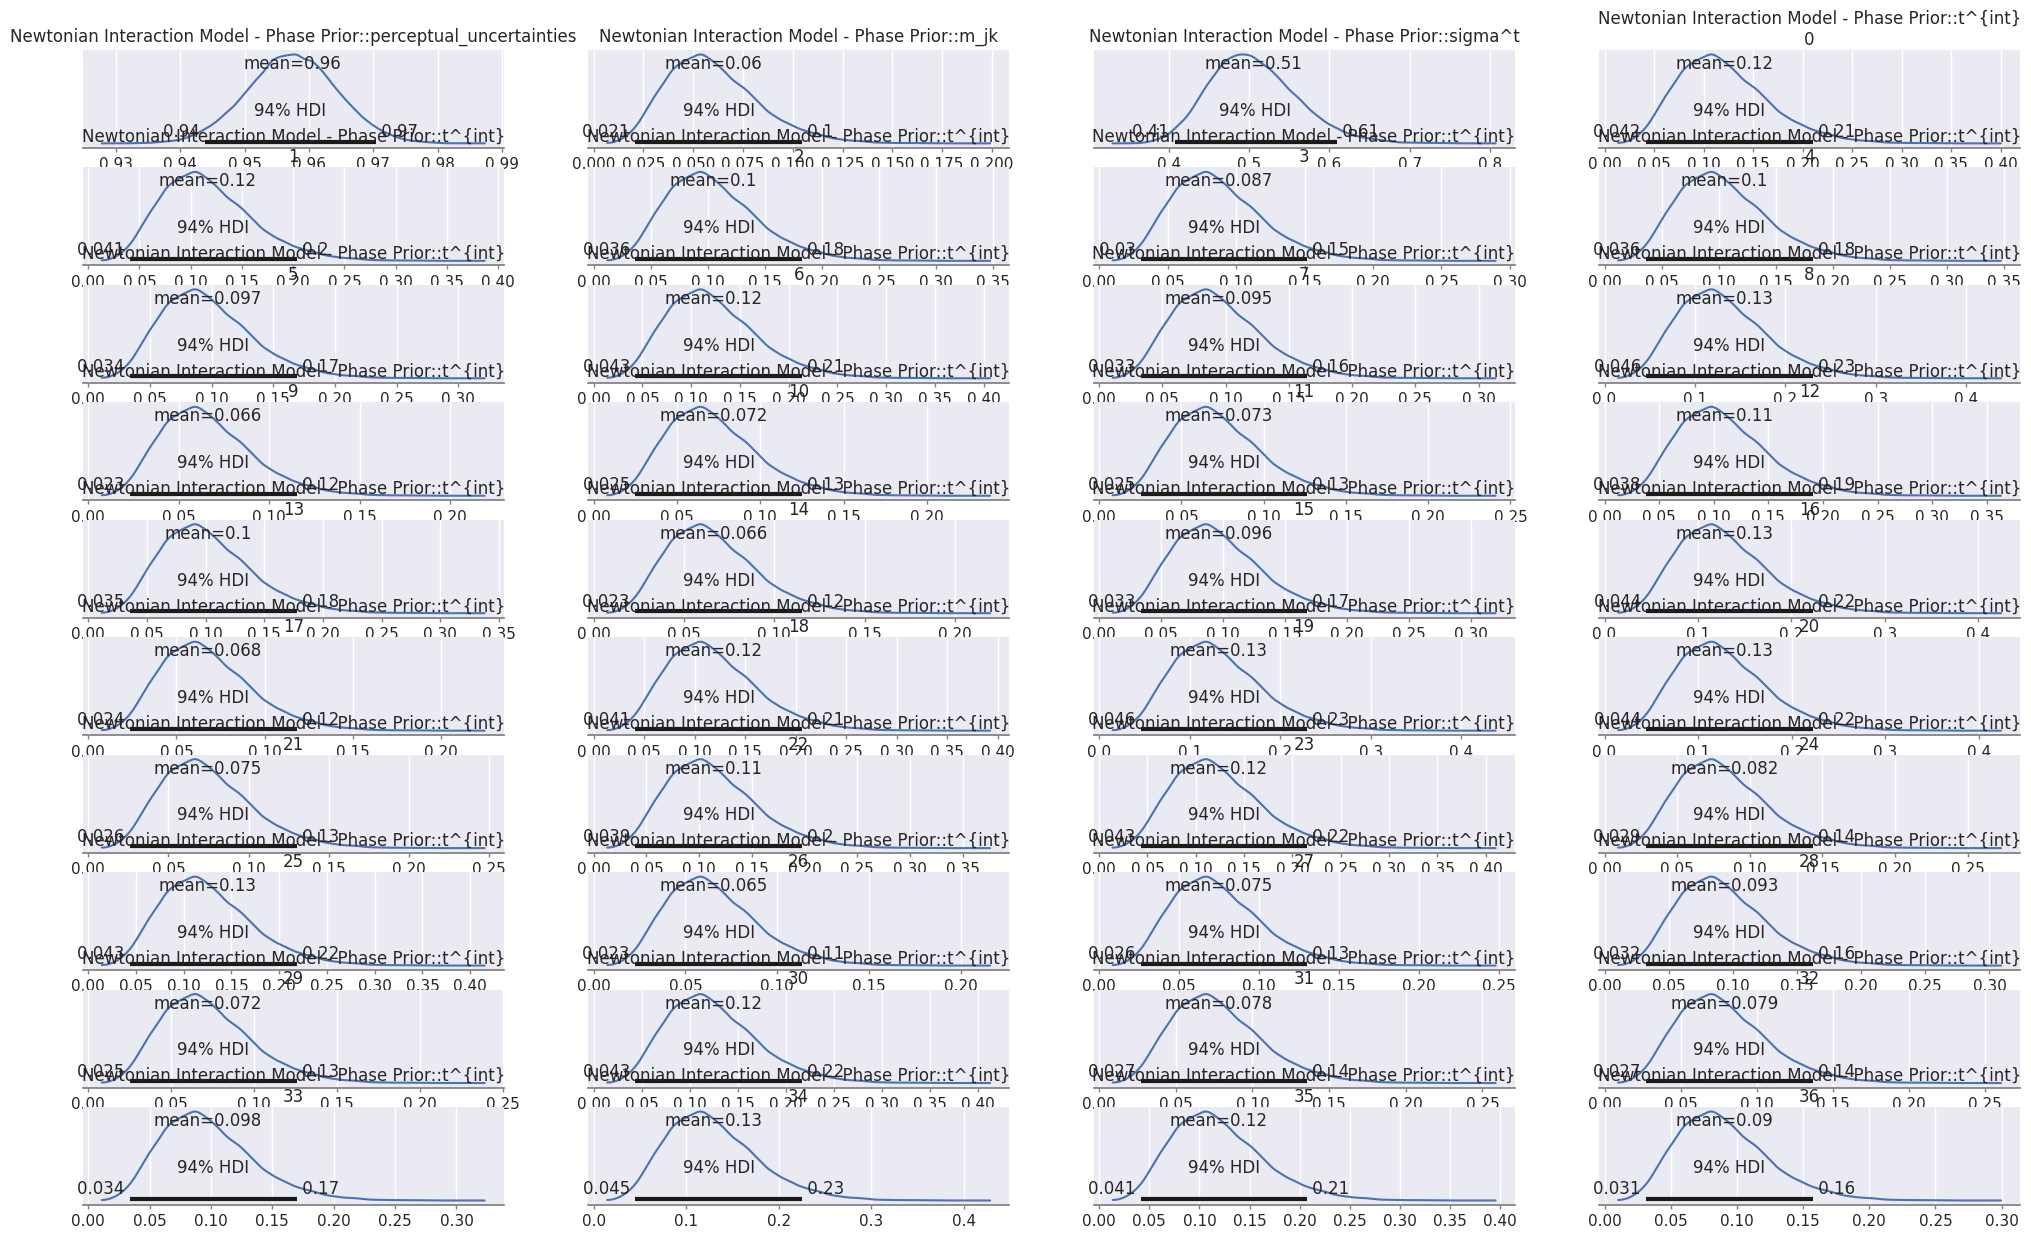

In [14]:
az.plot_posterior(idata, figsize=(25, 15))